In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

Вспомогательные функции

In [64]:
# RandomFunction генерирует рандомный временной ряд в виде ряда Фурье. Принимает последовательность точек x и кол-во периодов n
def RandomFunction(x, n=2):
    N = np.arange(0, n+1, 1)   # Генерятся периоды
    # Генерятся A и B - коэффициенты ряда Фурье
    A = np.random.randn(n)
    B = np.random.randn(n)
    A0 = np.random.randn(1)
    
    y = 0.5 * np.ones_like(x) * A0
    
    for n, a, b in zip(N, A, B):
        y += a*np.sin(n*x) + b*np.cos(n*x)
    return y
    
    

<h3> Авторегрессия</h3>

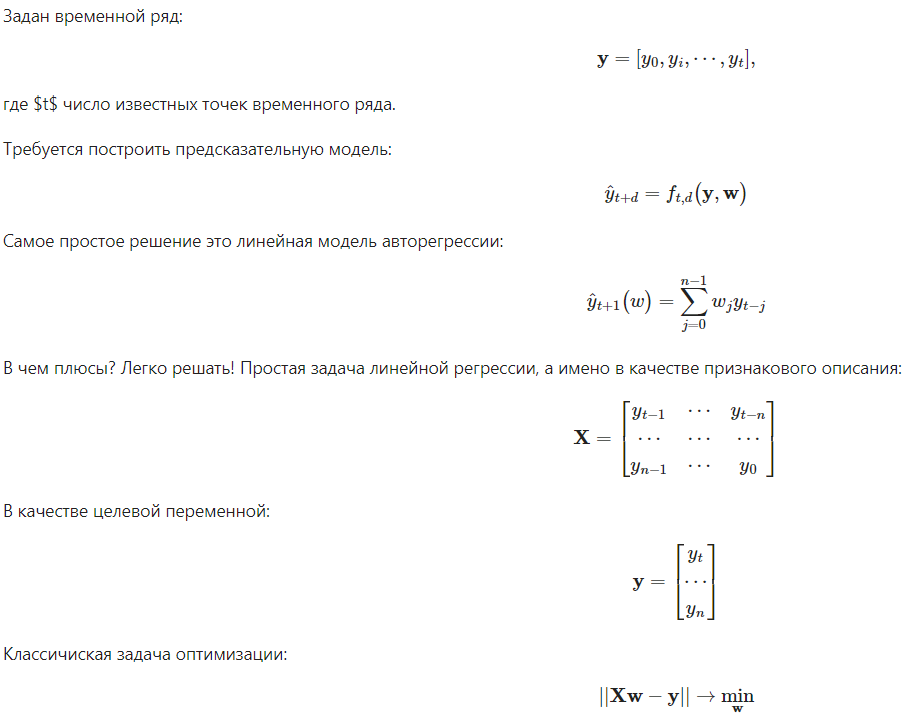

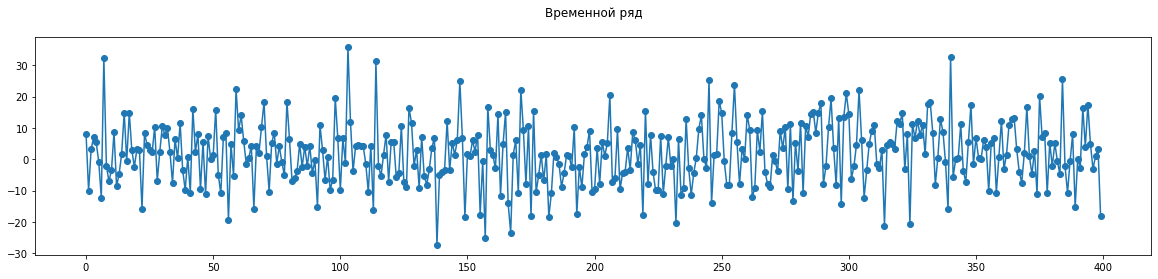

In [65]:
fig = plt.figure(figsize = (20, 4))

np.random.seed(0)
points = np.arange(400)
plt.title('Временной ряд\n')
series = RandomFunction(points, n=100)
plt.plot(series, '-o')
plt.show()

In [66]:
n = 100
X = np.zeros((len(series) - n, n))
y = np.zeros((len(series) - n, 1))

y = series[n: len(series)]
for j in range(len(series) - n):
    X[j] = series[j:j+n]

x_train = X[:-100]
y_train = y[:-100]
x_test = X[-100:]
y_test = y[-100:]

w = scipy.linalg.inv(x_train.T@x_train)@x_train.T@y_train

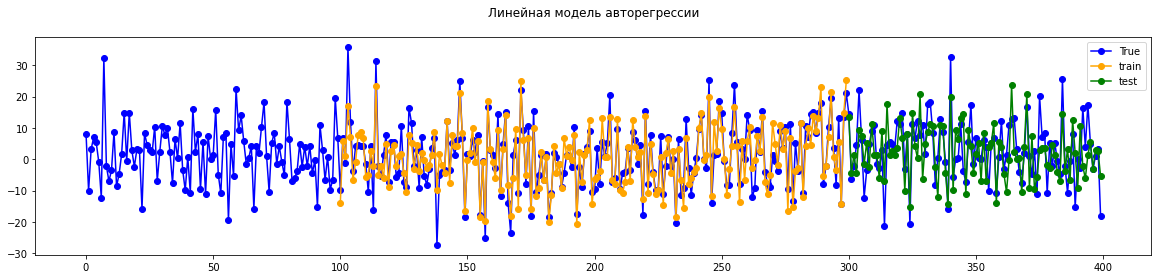

In [67]:
plt.figure(figsize = (20, 4))

plt.plot(series, '-o', c='blue', label = 'True')
plt.plot(points[n: len(series)-100], x_train@w, '-o', c='orange', label='train')
plt.plot(points[-100:], x_test@w, '-o', c='green', label='test')
plt.legend(loc='best')
plt.title('Линейная модель авторегрессии\n')
plt.show()

Эксперимент: как изменение n(кол-во признаков для каждой точки ряда) повлияет на качество?

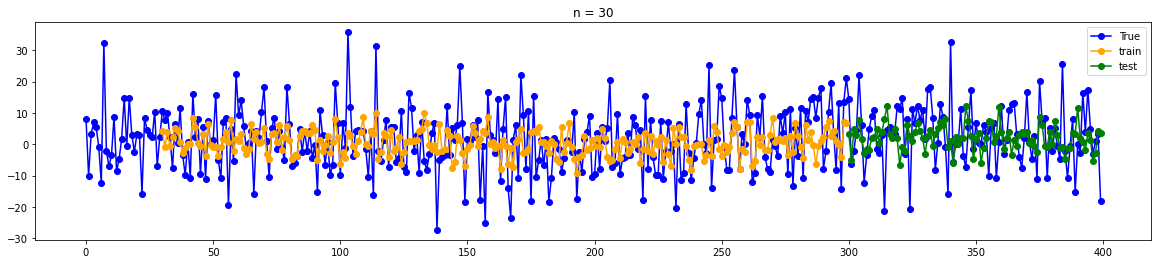

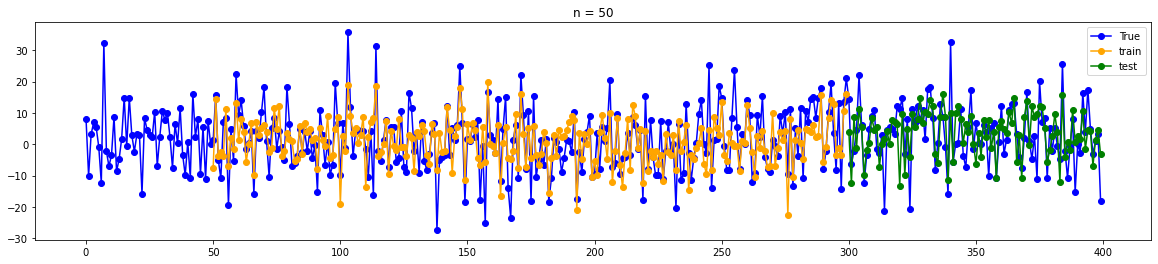

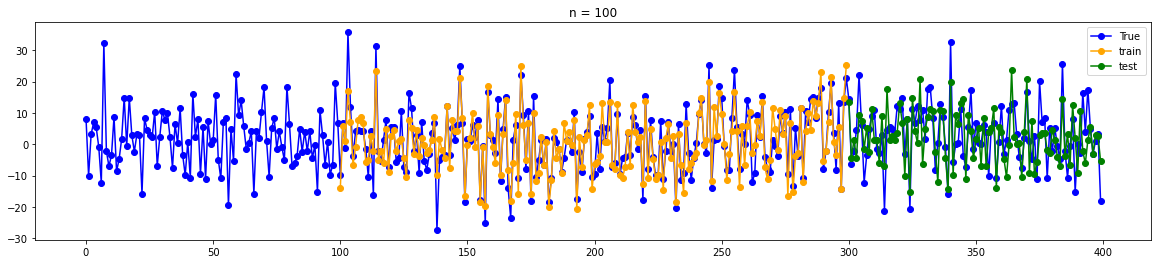

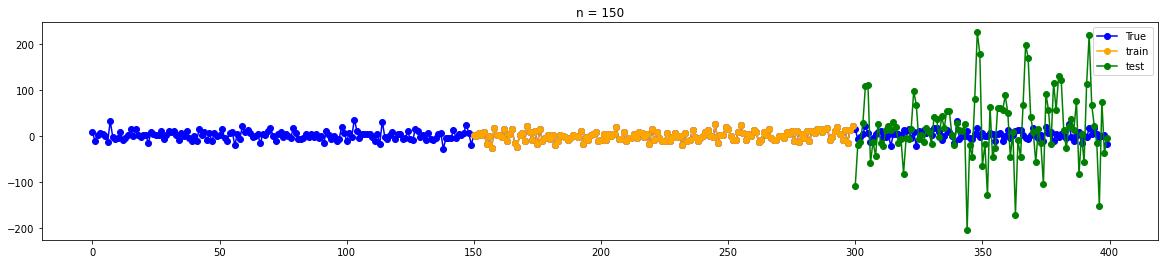

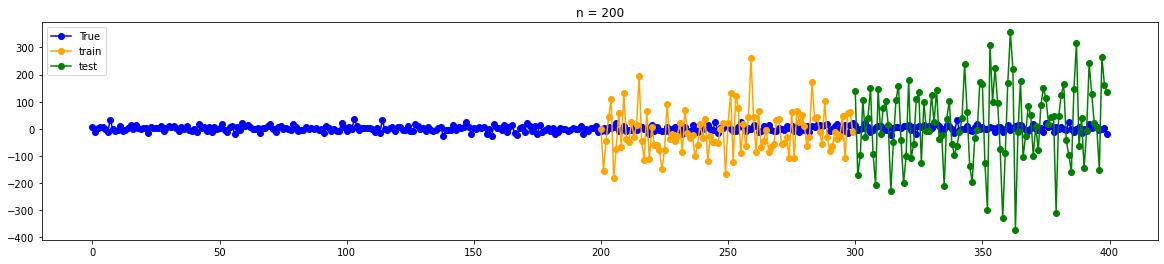

In [68]:
n = [30, 50, 100, 150, 200]
w_list = []
for n in n:
    X = np.zeros(shape = (len(series)-n, n))
    y = np.zeros((len(series)-n, 1))
    
    y = series[n: len(series)]
    for j in range(len(series) - n):
        X[j] = series[j:j+n]
        
    x_train = X[:-100]
    y_train = y[:-100]
    x_test = X[-100:]
    y_test = y[-100:]
    
    w = scipy.linalg.inv(x_train.T@x_train)@x_train.T@y_train
    w_list.append(w)
    
    plt.figure(figsize = (20, 4))
    plt.plot(points, series, '-o', c='blue', label='True')
    plt.plot(points[n:len(series)-100], x_train@w, '-o', c='orange', label='train')
    plt.plot(points[-100:], x_test@w, '-o', c='green', label = 'test')
    plt.title(f'n = {n}')
    plt.legend(loc='best')
    plt.show()
    

Выводы:

<ul>
    <li>при n=30 модель совсем недообучается</li>
    <li>при n=50 уже получше показывает себя на тесте</li>
    <li>при n=100 обучается нормально и на тесте дает адекватное качество</li>
    <li>при n=150 модель неустойчивая. Хорошо работает на обучающей выборке, но на тесте выдает большие пики</li>
    <li>при n=200 предсказания устремляются в сторону +- бесконечности, причем даже на бучающей выборке большие ошибки. Налицо сильное переобучение</li>
</ul>

Можно сравнить веса у моделей

In [69]:
print(f'n=30 | min: {np.min(w_list[0])}, max: {np.max(w_list[0])}')
print(f'n=50 | min: {np.min(w_list[1])}, max: {np.max(w_list[1])}')
print(f'n=100| min: {np.min(w_list[2])}, max: {np.max(w_list[2])}')
print(f'n=150| min: {np.min(w_list[3])}, max: {np.max(w_list[3])}')
print(f'n=200| min: {np.min(w_list[4])}, max: {np.max(w_list[4])}')

n=30 | min: -0.13945102862946018, max: 0.19559822277327488
n=50 | min: -0.15332099345151473, max: 0.5982894216717336
n=100| min: -0.623157549361359, max: 1.0068959129582224
n=150| min: -8.209405142287189, max: 9.16345823660884
n=200| min: -5.374634227253001, max: 4.061312836691352


Видно, что порядок весов у моделей с n=100 и n=150 различаются на порядок. Почему здесь возникает мультиколлениарность?

Данный ряд периодичен и период=100. Если мы обучаем точку по 100 предыдущим точкам, то мы обучаем по целому периоду. Следовательно, когда приходит очередь предсказывать новое значение, похожее значение уже есть среди признаков X и мы можем довольно точно предсказать новое значение. Ряд хорошо аппроксимируется, когда мы обучаемся на целом периоде ряда, а тестовые данные - это те же периоды, но с некоторым шумом.  

Если же мы обучаемся на n периодах, то при новом предсказании, в обучающей выборке есть n почти таких же признаков. Отсюда мультиколлениарность: веса при n мультиколлениарных признаках устремляются в +- бесконечность. Следовательно, если новые данные будут сколь угодно мало зашумленные, то при умножении на огромный коэффициент предсказания будут значительно отличаться от истинных значений

При сведении задачи к линейной регрессии, в комплекте идут все минусы линейной регрессии...

<h3>Экспоненциальное скользящее среднее</h3>

Недостаток ЭСС: из-за того, что при предсказании новой точки надо знать истинный ответ на предыдущей, адекватно предсказать получится только на 1 точку вперед

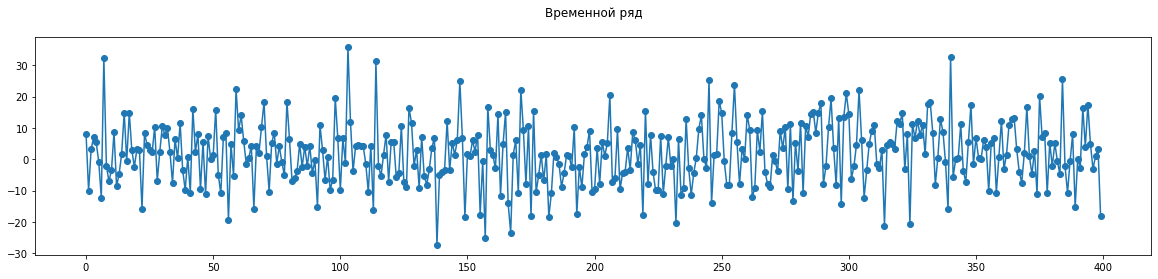

In [70]:
fig = plt.figure(figsize = (20, 4))

np.random.seed(0)
points = np.arange(400)
plt.title('Временной ряд\n')
series = RandomFunction(points, n=100)
plt.plot(series, '-o')
plt.show()

Предсказание ряда по ЭСС, начиная со 2 значения

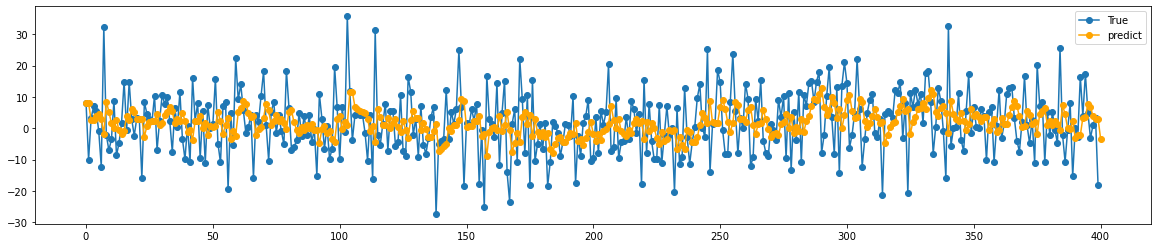

In [71]:
series_hat = [series[0]]
# Пусть alpha=0.3
alpha = 0.3
for t in range(len(series)):
    series_hat.append(series_hat[t] + alpha*(series[t] - series_hat[t]))
    
plt.figure(figsize = (20, 4))
plt.plot(series, '-o', label = 'True')
plt.plot(series_hat, '-o', c = 'orange', label='predict')
plt.legend(loc='best')
plt.show()

По графику заметно, что получилось сильное сглаживание

Эксперимент: Как коэффициент сглаживания повлияет на качество аппроксимации?

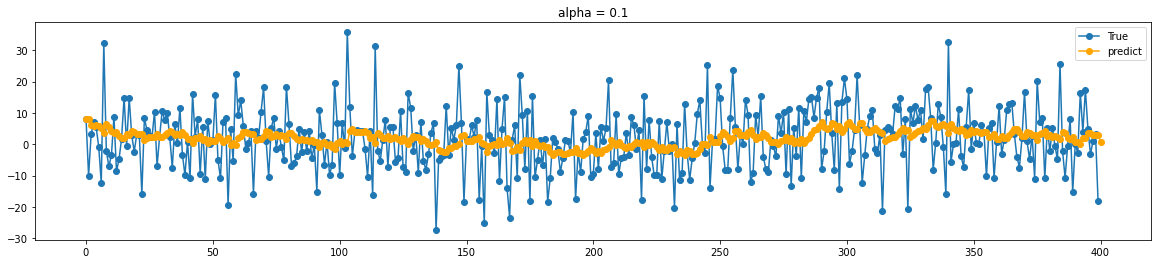

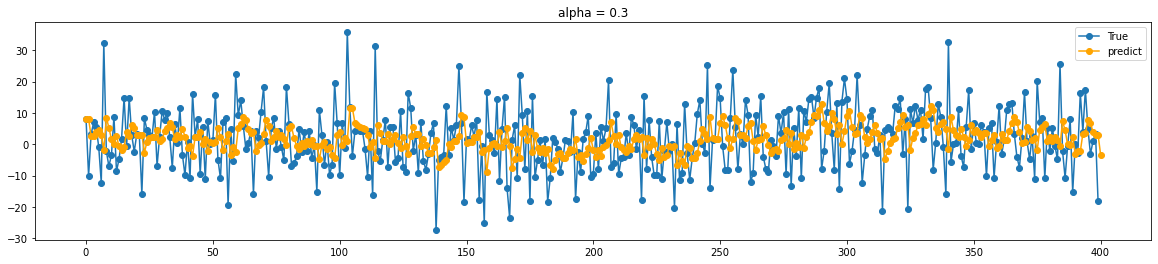

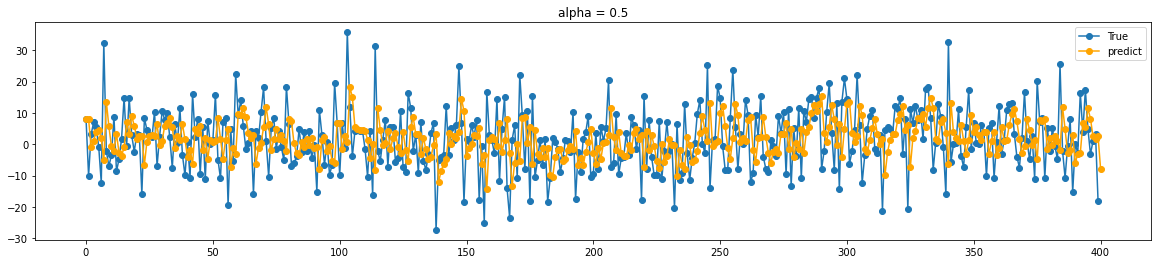

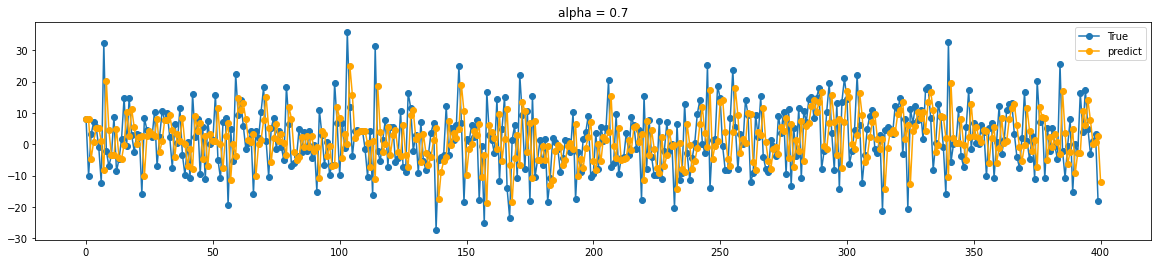

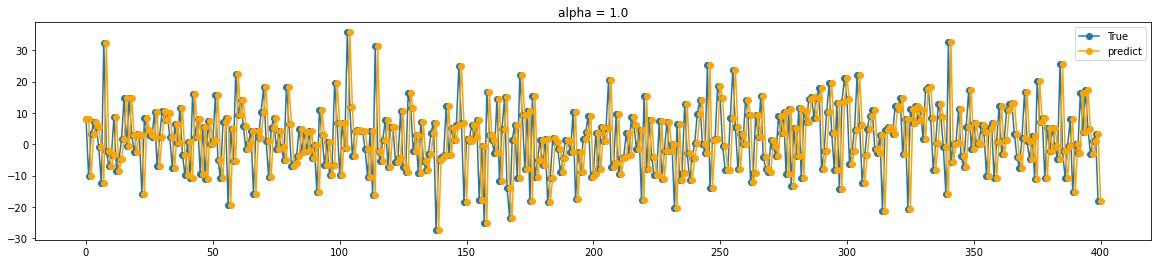

In [72]:
for alpha in [0.1, 0.3, 0.5, 0.7, 1.0]:
    series_hat = [series[0]]
    for t in range(len(series)):
        series_hat.append(series_hat[t] + alpha*(series[t] - series_hat[t]))
    plt.figure(figsize = (20, 4))
    plt.plot(series, '-o', label = 'True')
    plt.plot(series_hat, '-o', c = 'orange', label='predict')
    plt.title(f'alpha = {alpha}')
    plt.legend(loc='best')
    plt.show()

Чем меньше альфа, тем больше предыдущих точек ряда алгоритм усредняет, тем больше сглаживание

Это понятно из формулы ЭСС:

Если альфа=0, то второе слагаемое зануляется и каждое новое предсказание равно предыдущему предсказанию

Если альфа=1, то каждое новое предсказание равно предыдущей истинной точке

<h3>Подбор оптимального коэффициента сглаживания</h3>

In [73]:
%%time
# Функционал качества
def Q(y_pred, y_true, a):
    return np.sum((series_hat[1:] - series)**2)

LOO = {}

alpha = np.arange(0.05, 1.05, 0.05)
for alpha in alpha:
    series_hat = [series[0]]
    for i in range(len(series)):
        series_hat.append(series_hat[i] + alpha*(series[i] - series_hat[i]))
    LOO[np.round(alpha, 2)] = Q(series_hat, series, alpha)

LOO

Wall time: 8.01 ms


{0.05: 37147.55177295393,
 0.1: 34376.35994151004,
 0.15: 31742.04819486796,
 0.2: 29141.000860193086,
 0.25: 26561.735283471546,
 0.3: 24005.372785530562,
 0.35: 21480.631116590826,
 0.4: 19000.497652816888,
 0.45: 16580.24456546473,
 0.5: 14236.621211411592,
 0.55: 11987.687784492722,
 0.6: 9852.934676338116,
 0.65: 7853.529237739467,
 0.7: 6012.651106806971,
 0.75: 4355.936842783487,
 0.8: 2912.0801558042913,
 0.85: 1713.6442391785085,
 0.9: 798.1505624052177,
 0.95: 209.52349075657722,
 1.0: 2.7433870574225093e-28}